# part0: imports

In [1]:
%matplotlib inline


import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
import scipy.stats as stats
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection


import pyaldata as pyal

if "__file__" not in dir():
    try:
        nbPath = pathlib.Path.cwd()
        RepoPath = nbPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        import params
        mouse_defs = params.mouse_defs
        defs = mouse_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root
        reload(dt)
        reload(defs)
        reload(params)
    finally:
        os.chdir(nbPath)
    
    
    %run "S3-mouse-behaviour.ipynb"
    
    print('Done!')

Done!


# Part 1

functions that plot each panel.


In [7]:
@utility.report
def get_full_mouse_data():
    defs = mouse_defs
    
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str

---

In [172]:
def plot_traj(ax, df):
    df = pyal.restrict_to_interval(df, epoch_fun=defs.exec_epoch)
    
    for i,traj in enumerate(df.hTrjB):
        if df.target_id[i] in (0,):
            color = params.colors.RightTrial
            label = 'right'
        elif df.target_id[i] in (1,):
            color = params.colors.LeftTrial
            label = 'left'
        
        ax.plot(traj[:,0], -traj[:,1], color=color, lw=.4, label=label)
        ax.plot(traj[0,0], -traj[0,1], color=color, marker='o', ms=2)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True, min_n_ticks=3, nbins=3))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True, min_n_ticks=3, nbins=3))
        ax.set_xticklabels(np.int16(ax.get_xticks()-ax.get_xticks().min()))
        ax.set_yticklabels(np.int16(ax.get_yticks()-ax.get_yticks().min()))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('$X (mm)$')
        ax.set_ylabel('$Y (mm)$')
        ax.set_title(df.mouse[0])

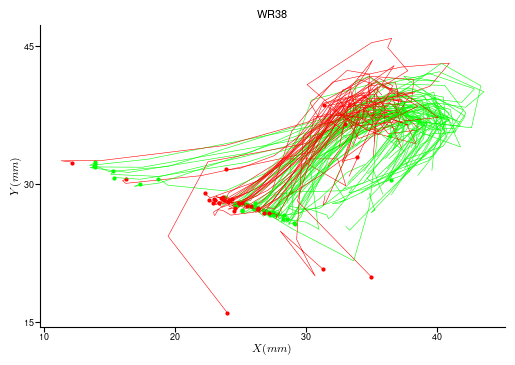

In [173]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    ax = fig.add_subplot()

    
    # allDFs_M1, _ = get_full_mouse_data()
    
    plot_traj(ax, allDFs_M1[2])
    plt.show()

---
plot firing rates

In [9]:
def plot_mean_fr(ax, df, signal = 'M1_rates'):
    df = pyal.restrict_to_interval(df, epoch_fun=defs.exec_epoch)
    fr = pyal.get_average_firing_rates(df,signal)
    
    bins = np.arange(fr.min(), fr.max(), 2)
    
    ax.hist(fr, bins=bins, label = 'M1' if 'M1' in signal else 'Striatum')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(MaxNLocator(min_n_ticks=4, nbins=3))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, min_n_ticks=3, nbins=6))
    ax.set_xlabel('mean firing rate ($1/s$)')
    ax. set_ylabel('\# of neurons')

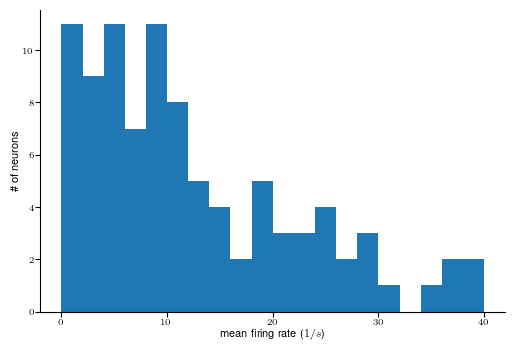

In [10]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    ax = fig.add_subplot()

    
    # allDFs_M1, _ = get_full_mouse_data()
    
    plot_mean_fr(ax, allDFs_M1[2])
    plt.show()

---
plot VAF distrbution

In [213]:
def plot_vaf(ax, df, field='M1_rates'):
    n_components = 20
    
    df_ = pyal.restrict_to_interval(df, epoch_fun=defs.exec_epoch)
    
    rates = np.concatenate(df_[field].values, axis=0)
    rates_model = PCA(n_components=n_components, svd_solver='full').fit(rates)
    
    ax.plot(np.arange(1,n_components+1), np.cumsum(rates_model.explained_variance_ratio_),
           label = 'M1' if 'M1' in field else 'Striatum')
    ax.set_yticks(np.arange(0,1,.2))
    ax.set_ylim([0,.9])
    ax.set_xticks(np.arange(1,n_components+1,3))
    ax.set_xlabel('Neural modes')
    ax.set_ylabel('VAF')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

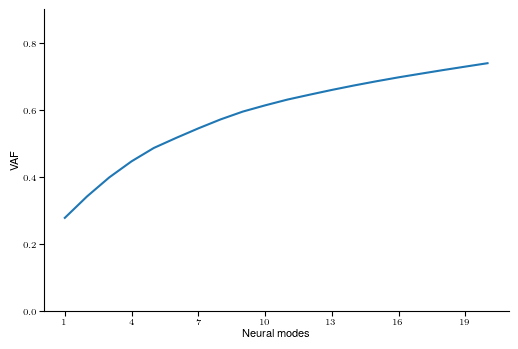

In [214]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    ax = fig.add_subplot()

    
    # allDFs_M1, _ = get_full_mouse_data()
    
    plot_vaf(ax, allDFs_M1[2])
    plt.show()

# Part 2

Plot figure

Executed: `get_full_mouse_data` in 0.8s


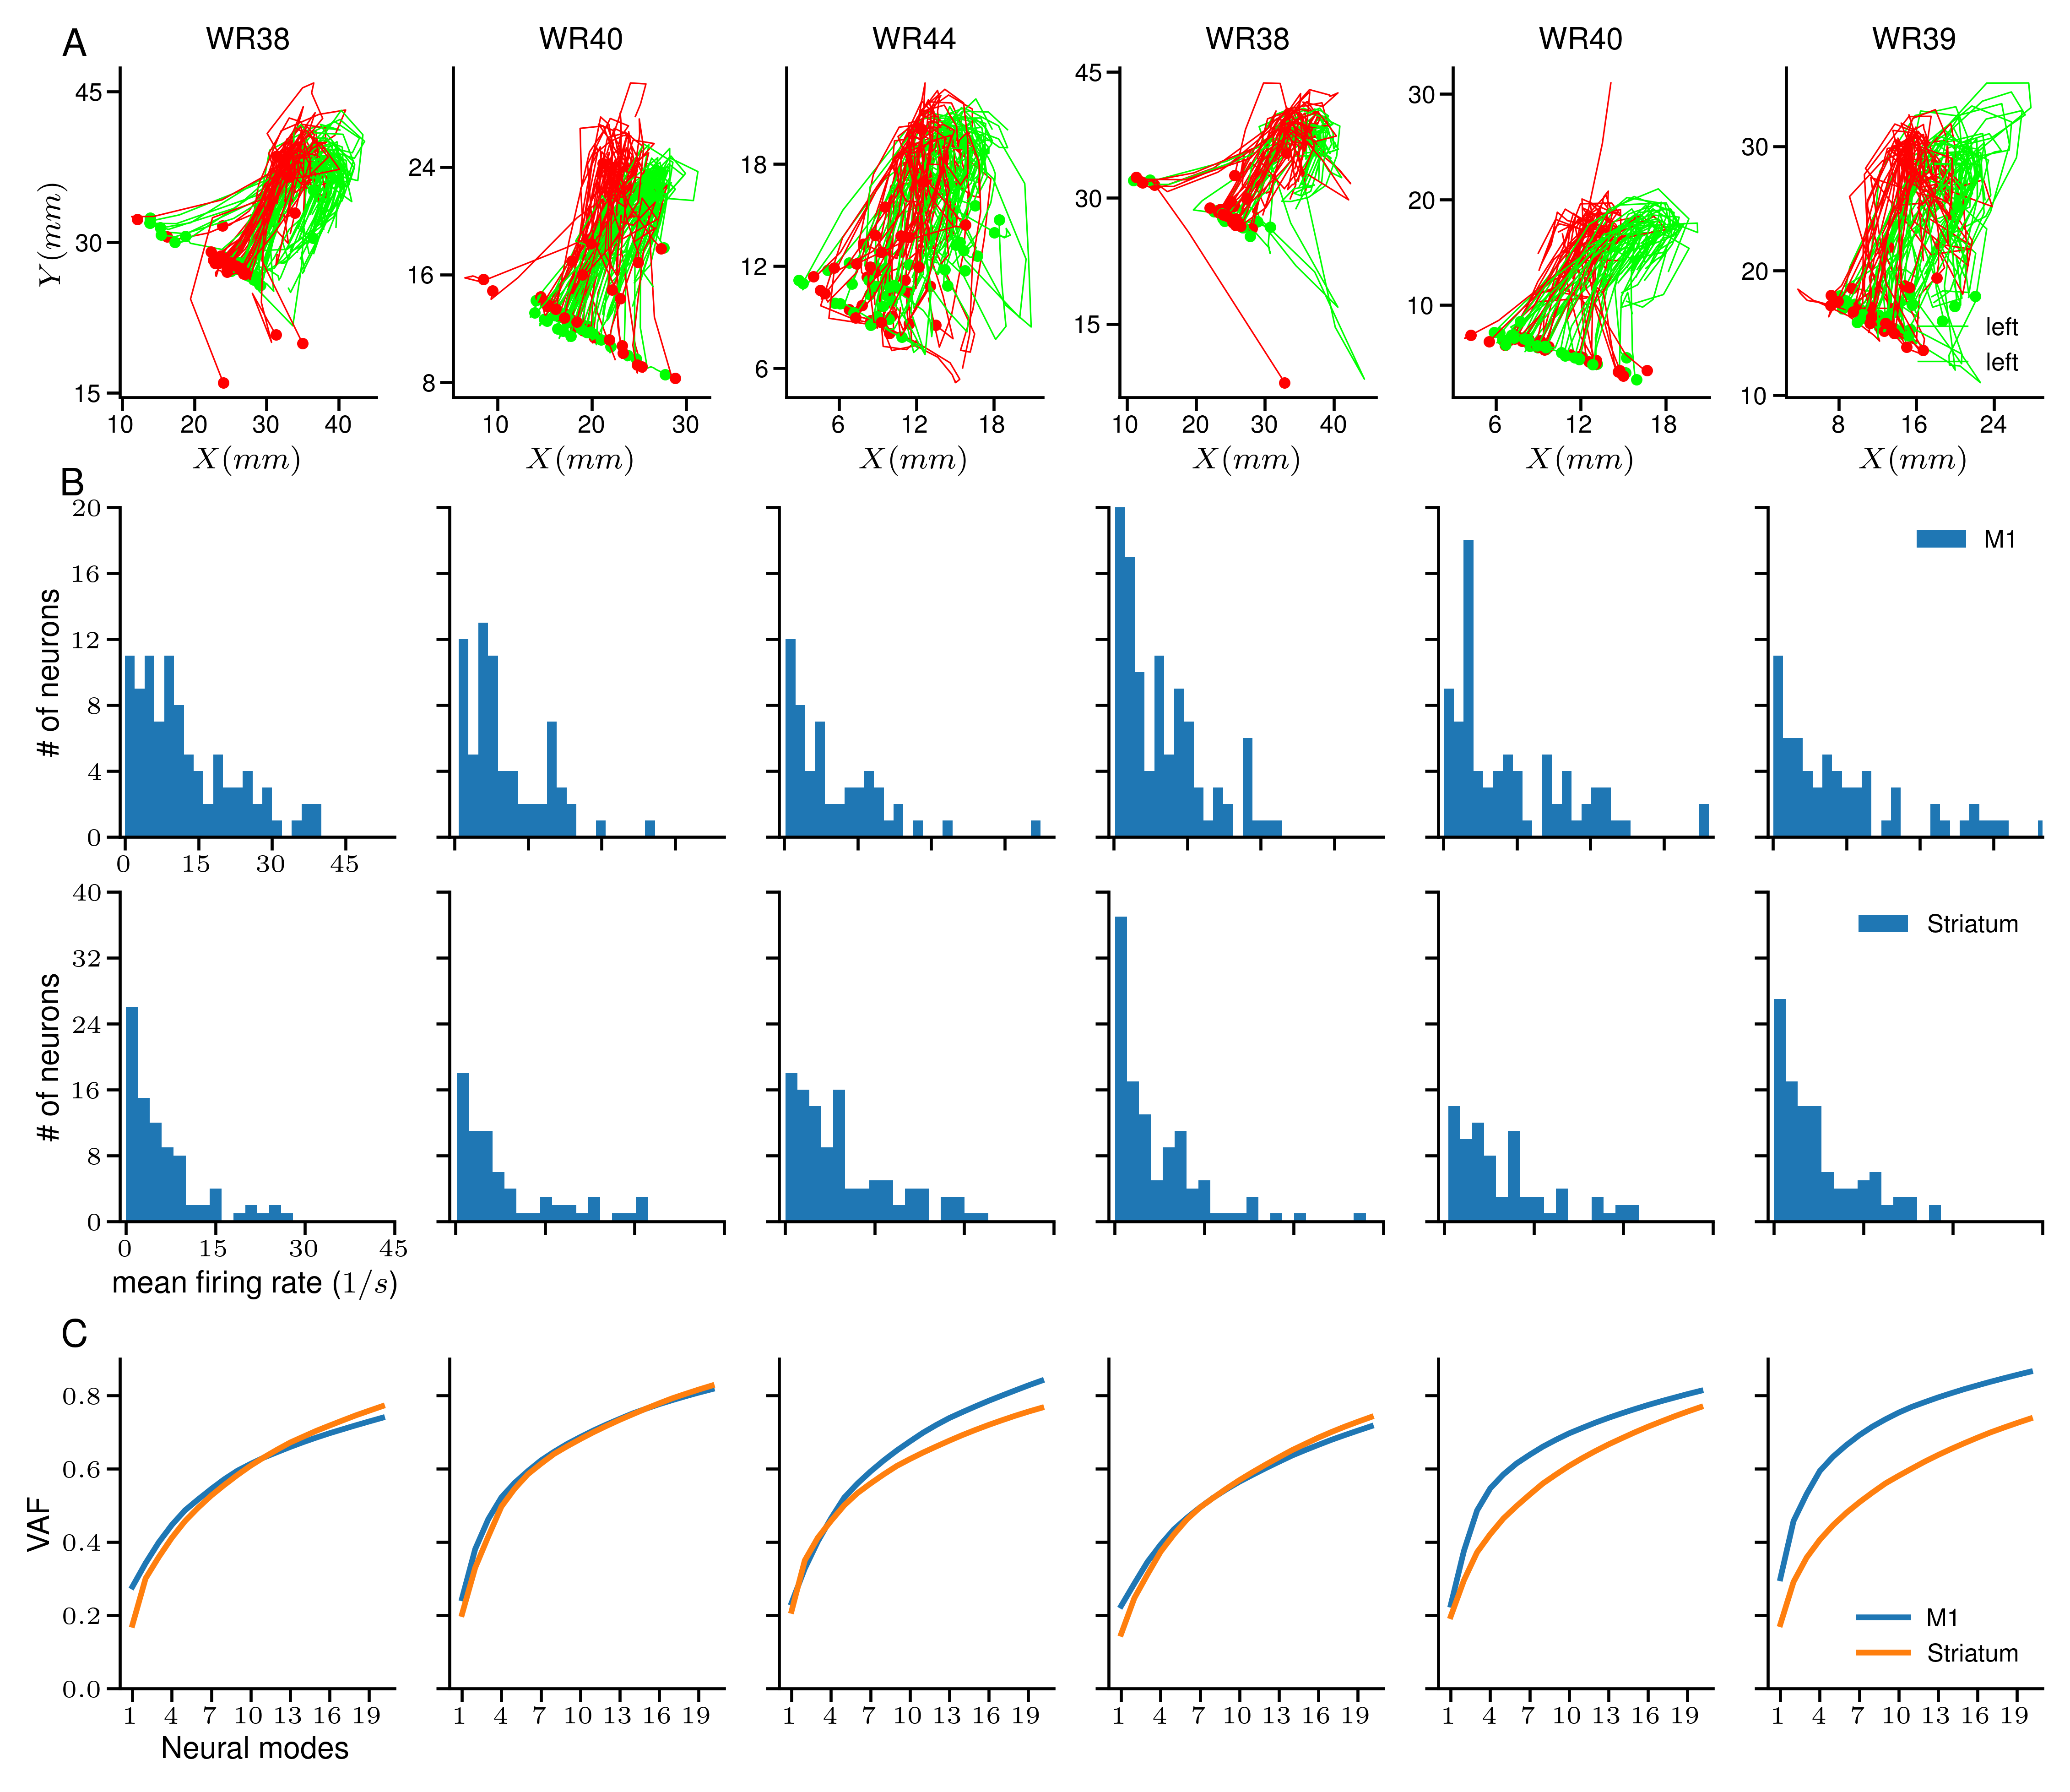

In [2]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    figsize=params.LargeFig
    fig=plt.figure(figsize=figsize)
    
   
    allDFs_M1, allDFs_Str = get_full_mouse_data()
    
    ##########################################
    # 1: trajectories
    gs1   =utility.add_gridspec_abs(fig, nrows=1, ncols=len(allDFs_M1), left=0, 
                                    bottom=figsize[1]-params.panels.SmallH, 
                                    width=figsize[0], 
                                    height=params.panels.SmallH,
                                    wspace=.3)
    
    axes1=[]
    for i, df in enumerate(allDFs_M1):
        axes1.append(ax:=fig.add_subplot(gs1[i]))
        plot_traj(ax, df)
        if i>0:
            ax.set_ylabel('')
    
    ax.legend([ax.get_legend_handles_labels()[0][0],ax.get_legend_handles_labels()[0][20]],
              [ax.get_legend_handles_labels()[1][0],ax.get_legend_handles_labels()[1][20]])

    
    
    
    ##########################################
    # 2: mean firing rates (M1)
    gs2   =utility.add_gridspec_abs(fig, nrows=1, ncols=len(allDFs_M1), left=0, 
                                    bottom=figsize[1]*gs1.bottom-params.panels.SmallH-.4, 
                                    width=figsize[0], 
                                    height=params.panels.SmallH)
    
    axes2=[]
    for i, df in enumerate(allDFs_M1):
        axes2.append(ax:=fig.add_subplot(gs2[i]))
        plot_mean_fr(ax, df, signal = 'M1_rates')
        ax.set_xlabel('')
        ax.set_ylim([0,20])
        ax.set_xlim([-1,55])
        if i>0:
            ax.set_ylabel('')
            ax.set_yticklabels([])
            ax.set_xticklabels([])
    
    ax.legend()
    
    

    ##########################################
    # 3: mean firing rates (Str)
    gs3   =utility.add_gridspec_abs(fig, nrows=1, ncols=len(allDFs_M1), left=0, 
                                    bottom=figsize[1]*gs2.bottom-params.panels.SmallH-.2, 
                                    width=figsize[0], 
                                    height=params.panels.SmallH)
    
    axes3=[]
    for i, df in enumerate(allDFs_M1):
        axes3.append(ax:=fig.add_subplot(gs3[i]))
        plot_mean_fr(ax, df, signal = 'Str_rates')
        ax.set_ylim([0,40])
        ax.set_xlim([-1,45])
        if i>0:
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.set_yticklabels([])
            ax.set_xticklabels([])
    
    ax.legend()




    
    ##########################################
    # 4: VAF (M1)
    gs4   =utility.add_gridspec_abs(fig, nrows=1, ncols=len(allDFs_M1), left=0, 
                                    bottom=figsize[1]*gs3.bottom-params.panels.SmallH-.5, 
                                    width=figsize[0], 
                                    height=params.panels.SmallH,
                                    hspace=.1)
    
    axes4=[]
    for i, df in enumerate(allDFs_M1):
        axes4.append(ax:=fig.add_subplot(gs4[i]))
        plot_vaf(ax, df, field = 'M1_rates')
        if i>0:
            ax.set_ylabel('')
            ax.set_yticklabels([])
    
    

    
    
    ##########################################
    # 5: VAF (Str) --> same axes as section-4

    
    for i, (df,ax) in enumerate(zip(allDFs_M1, axes4)):
        plot_vaf(ax, df, field = 'Str_rates')
        if i>0:
            ax.set_ylabel('')
            ax.set_yticklabels([])
            ax.set_xlabel('')
            ax.set_ylabel('')
    
    ax.legend()


    
    
    #############################################
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    AXES=(axes1[0],axes2[0],axes4[0])
    OFFX=np.array([.03]*len(AXES))
    OFFY=np.array([.01]*len(AXES))
#     # OFFX[[-1]]=0.12
#     # OFFX[[1]]=0.06
    
    params.add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)

    fig.savefig(params.figPath / 'figureS3-mouse-behaviour.pdf', format='pdf', bbox_inches='tight')